In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image
from random import shuffle
from keras.models import Model
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.regularizers import l1
from keras.models import Sequential
from keras.applications import ResNet152V2
from keras.applications import MobileNetV2
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D,Dense,Flatten, AveragePooling2D, Dropout, Input, DepthwiseConv2D, SeparableConv2D
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [2]:
Map = {'1':0, '2':1, '5':2, '10':3, '20':4, '50':5, '100':6, '200':7, '500':8, '1000':9}
notes = [1, 2, 5, 10, 20, 50, 100,200, 500, 1000]
IMG_SIZE = 100
training_data = []
validation_data = []
testing_data = []

In [3]:
def create_train_data():
    DIR = "TK4/Training/"
    for tki in range(0,10):
        DIR2 = DIR + str(notes[tki])
        
        sl = 0;
        for img in tqdm(os.listdir(DIR2)):
            label = tki
            #print(label)
            path = os.path.join(DIR2, img)
            #img = cv2.imread(path)
            #img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = Image.open(path)
            img = img.resize((IMG_SIZE, IMG_SIZE))
            training_data.append([np.array(img), label])
            sl = sl+1
          #  if sl==612:
           #     break
            
  
    shuffle(training_data)

In [4]:
create_train_data()

100%|████████████████████████████████████████████████████████████████████████████████| 900/900 [00:20<00:00, 44.01it/s]


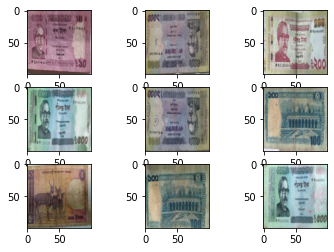

In [5]:
for i in range(9):
  plt.subplot(330+1+i)
  plt.imshow(training_data[i][0])
plt.show()

In [6]:
for i in range(9):
  print(notes[training_data[i][1]], end=' ')

10 1000 200 500 1000 100 1 100 500 

In [7]:
X = np.array([i[0] for i in training_data])
Y = np.array([i[1] for i in training_data])

X1, X2, Y1, Y2 = train_test_split(X, Y, test_size = 0.33, random_state=42, stratify=Y)
#X3, X4, Y3, Y4 = train_test_split(X2, Y2, test_size = 0.50, random_state=42, stratify=Y)

train_x = X1
train_y = Y1
val_x = X2
val_y = Y2
#test_x = X4
#test_y = Y4

print(Y1)

print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)
#print(test_y.shape)


train_len = train_y.shape[0]
val_len = val_y.shape[0]
#test_len = test_y.shape[0]
print(train_len)

[4 4 4 ... 0 4 9]
(6030, 100, 100, 3)
(6030,)
(2970, 100, 100, 3)
(2970,)
6030


In [8]:
train_x = train_x.reshape(train_len, IMG_SIZE, IMG_SIZE, 3)
val_x = val_x.reshape(val_len, IMG_SIZE, IMG_SIZE, 3)
#test_x = test_x.reshape(test_len, IMG_SIZE, IMG_SIZE, 3)

train_x = train_x.astype('float32')
val_x = val_x.astype('float32')
#test_x = test_x.astype('float32')

train_x/=255
val_x/=255
#test_x/=255

In [9]:
print(train_y)
n_classes = 10
train_y = np_utils.to_categorical(train_y, n_classes)
val_y = np_utils.to_categorical(val_y, n_classes)
#test_y = np_utils.to_categorical(test_y, n_classes)

[4 4 4 ... 0 4 9]


In [10]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3)))

baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 50, 50, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 50, 50, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 50, 50, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [11]:
from keras.layers import BatchNormalization
from keras.layers import Activation
headModel = baseModel.output
#headModel = AveragePooling2D(pool_size=(1, 1))(headModel)
#headModel2 = Conv2D(32, kernel_size=(2,2), strides=(1,1), padding="valid", activation="relu")(headModel2)
#headModel2 = MaxPool2D(pool_size=(2,2))(headModel2)

headModel = Flatten(name="flatten")(headModel)
headModel = Dense(1024, activation="relu", activity_regularizer=l1(0.0001))(headModel)
headModel = BatchNormalization()(headModel)
headModel = Activation("relu")(headModel)

headModel = Dropout(0.2)(headModel)

headModel = Dense(512, activation="relu")(headModel)
headModel = BatchNormalization()(headModel)
headModel = Activation("relu")(headModel)
headModel = Dense(256, activation="relu")(headModel)

headModel = Dense(n_classes, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

#model.summary()
print(type(model))

<class 'tensorflow.python.keras.engine.functional.Functional'>


In [12]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
his2 = model.fit(train_x, train_y, batch_size=64, epochs=50, validation_data=(val_x, val_y))

Epoch 1/50
95/95 [==============================] - 166s 2s/step - loss: 0.7120 - accuracy: 0.8685 - val_loss: 0.1047 - val_accuracy: 0.9879
Epoch 2/50
95/95 [==============================] - 130s 1s/step - loss: 0.0981 - accuracy: 0.9902 - val_loss: 0.3407 - val_accuracy: 0.9286
Epoch 3/50
95/95 [==============================] - 131s 1s/step - loss: 0.1396 - accuracy: 0.9840 - val_loss: 0.1408 - val_accuracy: 0.9788
Epoch 4/50
95/95 [==============================] - 130s 1s/step - loss: 0.1119 - accuracy: 0.9880 - val_loss: 0.2205 - val_accuracy: 0.9620
Epoch 5/50
95/95 [==============================] - 130s 1s/step - loss: 0.1437 - accuracy: 0.9816 - val_loss: 0.3640 - val_accuracy: 0.9182
Epoch 6/50
95/95 [==============================] - 130s 1s/step - loss: 0.1096 - accuracy: 0.9877 - val_loss: 0.0646 - val_accuracy: 0.9943
Epoch 7/50
95/95 [==============================] - 130s 1s/step - loss: 0.1037 - accuracy: 0.9864 - val_loss: 0.1268 - val_accuracy: 0.9811
Epoch 8/50
95

In [13]:
#scores = model.evaluate(test_x, test_y)
#print(scores[1]*100) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


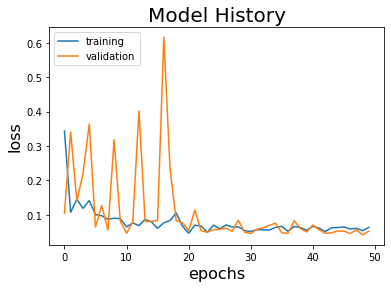

In [14]:
print(his2.history.keys())
plt.plot(his2.history['loss'])
plt.plot(his2.history['val_loss'])
plt.title("Model History", fontsize=20)
plt.xlabel("epochs", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [15]:
y_prediction = model.predict(val_x)
y_prediction=np.argmax(y_prediction, axis=1)
validation_y=np.argmax(val_y, axis=1)
print("f1 score: ", f1_score(validation_y, y_prediction, average="macro"))
print("precision score: ", precision_score(validation_y, y_prediction, average="macro"))
print("recall score: ", recall_score(validation_y, y_prediction, average="macro"))    

f1 score:  0.9979763691955137
precision score:  0.9979819888470729
recall score:  0.997979797979798


In [16]:
def decode_predicted_data(predicted_dat):
    mx = predicted_dat.max()
    idx = -1
    
    for i in range(9):
        if mx==predicted_dat[i]:
            idx = i
    
    return notes[idx]

Probability of classes:  [3.7582676e-10 7.0270756e-10 6.0838369e-11 4.4515758e-10 1.6391011e-08
 2.7889802e-09 1.0000000e+00 8.4572947e-14 5.5993592e-08 4.7152431e-11]

Note of 100 tk. 

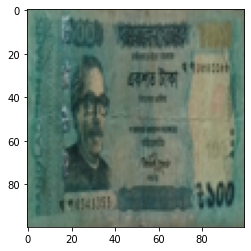

In [17]:
np_img = val_x[127]

plt.imshow(np_img)
org = np_img
data = org.reshape(1,IMG_SIZE,IMG_SIZE,3)
    
predicted_data = model.predict(data)[0]

print("Probability of classes: ", predicted_data)
    
ret = decode_predicted_data(predicted_data)
    
print("\nNote of", ret, "tk.", end=' ')

plt.show()